# **Homework 2**

## First Iteration ##

In [4]:
import tensorflow as tf

# Check if GPU is available
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

GPU is available


In [5]:
# Cell 1: Import Libraries
import numpy as np
import sys
import gymnasium as gym
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from gymnasium.wrappers import RecordVideo

In [6]:
# Cell 2: Data Preparation
# Define the paths to your training and validation data
trainingset = 'train/'
validationset = 'test/'

batch_size = 64
target_size = (96, 96)  # Adjust based on your dataset

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=20,
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validationset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Gather dataset information
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = list(train_generator.class_indices.keys())
img_h, img_w, img_channels = input_shape
print(f"Image height = {img_h}, Image Width = {img_w}, Channels = {img_channels}")
print(f"Image input shape: {input_shape}")
print(f"Classes: {classnames}")
print(f"Loaded {num_samples} training samples from {num_classes} classes.")
print(f"Loaded {validation_generator.n} validation samples from {validation_generator.num_classes} classes.")

Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image height = 96, Image Width = 96, Channels = 3
Image input shape: (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 validation samples from 5 classes.


In [7]:
# Cell 3: Model Variation 1 - Basic CNN
def BasicCNN(input_shape, num_classes):
    model = Sequential(name="BasicCNN")

    # Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model_basic = BasicCNN(input_shape, num_classes)
model_basic.summary()

Model: "BasicCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                          

In [8]:
# Cell 4: Model Variation 2 - CNN with Batch Normalization
def CNNWithBatchNorm(input_shape, num_classes):
    model = Sequential(name="CNNWithBatchNorm")

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model_batchnorm = CNNWithBatchNorm(input_shape, num_classes)
model_batchnorm.summary()

Model: "CNNWithBatchNorm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation_4 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)   

In [9]:
# Cell 5: Model Variation 3 - Deeper CNN with Different Activation
def DeepCNN(input_shape, num_classes):
    model = Sequential(name="DeepCNN")

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model_deep = DeepCNN(input_shape, num_classes)
model_deep.summary()

Model: "DeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        36928     
                                                           

In [ ]:
# Cell AH: Regression-Based Model
def RegressionCNN(input_shape, num_outputs=3):
    model = Sequential(name="RegressionCNN")

    # Convolutional Layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for regression
    model.add(Dense(num_outputs, activation='tanh'))  # tanh to bound outputs between -1 and 1

    # Compile the model with regression loss
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

# Instantiate and summarize the regression model
model_regression = RegressionCNN(input_shape, num_outputs=3)
model_regression.summary()

Model: "CNNWithGAP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0

In [ ]:
# Cell 7: Select Model
# Choose one of the models defined above
model = model_regression  # Replace with model_basic, model_deep, or model_regression as desired

In [12]:
# Cell 8: Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for potentially longer training
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

# Optionally, add ModelCheckpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# Cell 9: Train the Model
# Calculate steps per epoch and validation steps
steps_per_epoch = int(np.ceil(train_generator.n / batch_size))
val_steps = int(np.ceil(validation_generator.n / batch_size))


try:
    history = model.fit(
        train_generator,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted.")

# Save the final model
model.save('models/model_final.keras')

Epoch 1/100
100/100 [==============================] - 19s 141ms/step - loss: 1.5132 - accuracy: 0.3029 - val_loss: 1.5116 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 13s 131ms/step - loss: 1.4979 - accuracy: 0.3271 - val_loss: 1.4057 - val_accuracy: 0.6952 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 1.4390 - accuracy: 0.4081 - val_loss: 1.3865 - val_accuracy: 0.6057 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 13s 131ms/step - loss: 1.3985 - accuracy: 0.4363 - val_loss: 1.3014 - val_accuracy: 0.6282 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 1.3808 - accuracy: 0.4362 - val_loss: 1.3088 - val_accuracy: 0.6115 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 14s 136ms/step - loss: 1.3722 - accuracy: 0.4536 - val_loss: 1.2010 - val_accuracy: 0.6693 - lr: 1.0000e-04
Epoch 7/100
100/100 [=

In [15]:
# Cell 10: Evaluate the Model
# Load the best saved model
best_model = load_model('models/best_model.keras')

# Evaluate on validation data
val_steps = int(np.ceil(validation_generator.n / batch_size))
loss, acc = best_model.evaluate(validation_generator, steps=val_steps, verbose=1)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')

43/43 [==============================] - 2s 28ms/step - loss: 1.4057 - accuracy: 0.6952
Loss: 1.4057
Accuracy: 0.6952


In [16]:
# Cell 11: Classification Report
preds = best_model.predict(validation_generator, steps=val_steps, verbose=0)
Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # Ensure shuffle=False in validation_generator

print(classification_report(Ytest, Ypred, target_names=classnames, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       133
           1      0.000     0.000     0.000       275
           2      0.379     0.424     0.400       406
           3      0.758     0.917     0.830      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.695      2749
   macro avg      0.227     0.268     0.246      2749
weighted avg      0.579     0.695     0.631      2749



c:\Users\andri\miniconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\miniconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\miniconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


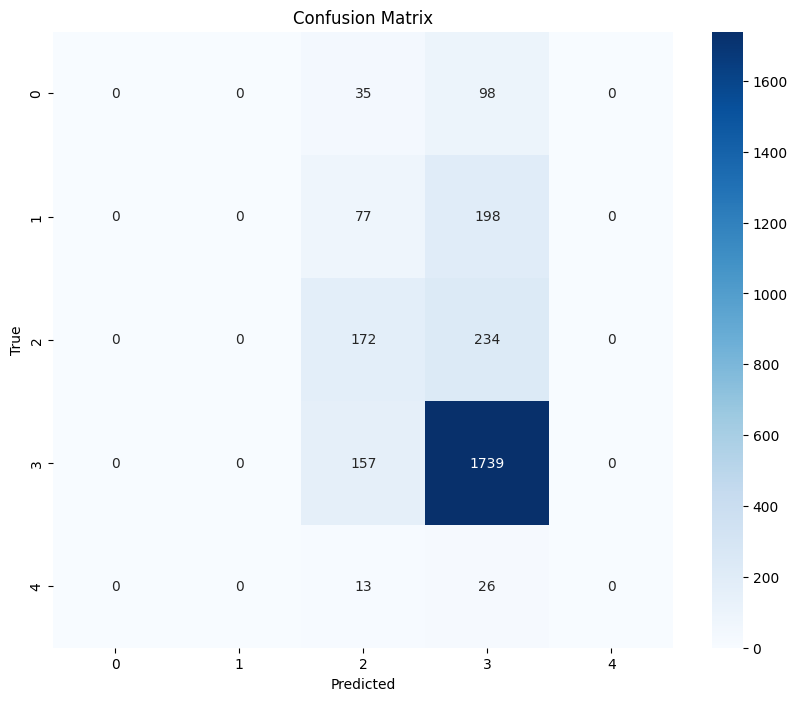

In [18]:
# Cell 12: Confusion Matrix
cm = confusion_matrix(Ytest, Ypred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classnames, yticklabels=classnames, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Cell 13: Text-Based Confusion Matrix
conf = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i][j] > 0:
            conf.append([i, j, cm[i][j]])

conf = np.array(conf)
conf = conf[np.argsort(-conf[:, 2])]  # Sort by descending error count

print(f'{"True":<16} {"Predicted":<16} {"Errors":<10} {"Error %":<10}')
print('-' * 60)
for k in conf:
    true_class = classnames[int(k[0])]
    pred_class = classnames[int(k[1])]
    errors = int(k[2])
    error_pct = (errors / validation_generator.n) * 100
    print(f'{true_class:<16} -> {pred_class:<16} {errors:<10} {error_pct:.2f}%')

True             Predicted        Errors     Error %   
------------------------------------------------------------
2                -> 3                234        8.51%
1                -> 3                198        7.20%
3                -> 2                157        5.71%
0                -> 3                98         3.56%
1                -> 2                77         2.80%
0                -> 2                35         1.27%
4                -> 3                26         0.95%
4                -> 2                13         0.47%


In [21]:
# Cell 9: Model Deployment with Gymnasium (Final Revised for Continuous Actions)
import numpy as np
from gymnasium.wrappers import RecordVideo

def play(env, model, predefined_actions):
    seed = 2000
    obs, _ = env.reset(seed=seed)

    # Drop initial frames with no action
    no_action = predefined_actions[0]  # [0.0, 0.0, 0.0]
    for _ in range(50):
        obs, _, _, _, _ = env.step(no_action)

    done = False
    while not done:
        # Preprocess the observation
        img = preprocess_observation(obs, target_size)
        p = model.predict(np.expand_dims(img, axis=0))  # Shape: (1, 5)
        predicted_class = np.argmax(p)  # Integer 0-4

        # Map the predicted class to a predefined action
        action = predefined_actions.get(predicted_class, predefined_actions[0])  # Array

        # Ensure the action is a float32 NumPy array
        action = action.astype(np.float32)

        # Step the environment with the action
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

def preprocess_observation(obs, target_size):
    from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

    # Convert observation to PIL Image
    img = array_to_img(obs)
    # Resize image
    img = img.resize(target_size)
    # Convert to array and normalize
    img = img_to_array(img) / 255.0
    return img

# Define predefined actions (Continuous)
predefined_actions = {
    0: np.array([0.0, 0.0, 0.0], dtype=np.float32),  # No Action
    1: np.array([-1.0, 0.0, 0.0], dtype=np.float32), # Steer Left
    2: np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Steer Right
    3: np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Accelerate (Gas)
    4: np.array([0.0, 0.0, 1.0], dtype=np.float32),  # Brake
    # Add more actions as needed
}

# Initialize the environment without 'continuous' parameter
env_arguments = {
    'domain_randomize': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v3'
env = gym.make(env_name, **env_arguments)

# Wrap the environment to record videos
video_dir = 'video_recordings'  # Specify the directory to save video recordings
env = RecordVideo(env, video_dir)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

best_model = load_model('models/best_model.keras')

# Play the game using the trained model
play(env, best_model, predefined_actions)

Environment: CarRacing-v3
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Observation space: Box(0, 255, (96, 96, 3), uint8)
1/1 [==============================] - 0s 17ms/step
